<a href="https://colab.research.google.com/github/malihamostafa023-cmd/CNN/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Verify the dataset folders exist
import os

DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/chest_xray" # Moved to the next cell

for split in ["train", "val", "test"]:
    path = os.path.join(DATA_DIR, split)
    if not os.path.isdir(path):
        print(f"Missing: {path}")
    else:
        print(f"Found: {path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found: /content/drive/MyDrive/Colab Notebooks/chest_xray/train
Found: /content/drive/MyDrive/Colab Notebooks/chest_xray/val
Found: /content/drive/MyDrive/Colab Notebooks/chest_xray/test


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # <-- NEW for progress bar

# ===============================
# Device
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# Data transforms
# ===============================
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
}

# ===============================
# Load dataset
# ===============================
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                  for x in ["train", "val", "test"]}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
               for x in ["train", "val", "test"]}

class_names = image_datasets["train"].classes
print("Classes:", class_names)

# ===============================
# Small CNN Model
# ===============================
class SmallCNN(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        def block(c_in, c_out):
            return nn.Sequential(
                nn.Conv2d(c_in, c_out, 3, padding=1),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.Conv2d(c_out, c_out, 3, padding=1),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )
        self.features = nn.Sequential(
            block(3, 32),
            block(32, 64),
            block(64, 128)
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

model = SmallCNN(n_classes=2).to(device)

# ===============================
# Loss & Optimizer
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ===============================
# Training Loop (with % progress)
# ===============================
best_acc = 0.0
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss, running_corrects = 0.0, 0

        # Use tqdm for % progress
        loop = tqdm(dataloaders[phase], desc=f"{phase}", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = outputs.argmax(1)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Update tqdm progress bar with current loss & accuracy
            loop.set_postfix(loss=loss.item(), acc=(torch.sum(preds == labels).item()/labels.size(0))*100)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Save best model
        if phase == "val" and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), "best_scratch.pth")
            print("✅ Saved best model")

print("\nTraining complete. Best val Acc: {:.4f}".format(best_acc))


Using device: cuda
Classes: ['NORMAL', 'PNEUMONIA']

Epoch 1/10


train Loss: 0.3202 Acc: 0.8489


val Loss: 0.4748 Acc: 0.6250
✅ Saved best model

Epoch 2/10


train Loss: 0.2470 Acc: 0.8955


val Loss: 0.5390 Acc: 0.7500
✅ Saved best model

Epoch 3/10


train Loss: 0.2067 Acc: 0.9181


val Loss: 1.0834 Acc: 0.6875

Epoch 4/10


train Loss: 0.1937 Acc: 0.9218


val Loss: 4.9011 Acc: 0.5000

Epoch 5/10


train Loss: 0.1795 Acc: 0.9281


val Loss: 0.5596 Acc: 0.7500

Epoch 6/10


train Loss: 0.1566 Acc: 0.9379


val Loss: 1.6396 Acc: 0.5625

Epoch 7/10


train Loss: 0.1443 Acc: 0.9431


val Loss: 0.9758 Acc: 0.6250

Epoch 8/10


train Loss: 0.1348 Acc: 0.9452


val Loss: 1.6408 Acc: 0.5000

Epoch 9/10


train Loss: 0.1436 Acc: 0.9419


val Loss: 0.9981 Acc: 0.6250

Epoch 10/10


train Loss: 0.1311 Acc: 0.9492


val Loss: 3.8549 Acc: 0.5000

Training complete. Best val Acc: 0.7500


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# ===============================
# Device
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# Data transforms (simple normalization)
# ===============================
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
}

# ===============================
# Load dataset
# ===============================
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                  for x in ["train", "val", "test"]}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
               for x in ["train", "val", "test"]}

class_names = image_datasets["train"].classes
print("Classes:", class_names)

# ===============================
# Deep CNN Model
# ===============================
class DeepCNN(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        def block(c_in, c_out):
            return nn.Sequential(
                nn.Conv2d(c_in, c_out, kernel_size=3, padding=1),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.Conv2d(c_out, c_out, kernel_size=3, padding=1),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)  # halve size
            )
        self.features = nn.Sequential(
            block(3, 32),    # 224 -> 112
            block(32, 64),   # 112 -> 56
            block(64, 128),  # 56 -> 28
            block(128, 256), # 28 -> 14
            block(256, 512)  # 14 -> 7
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # 512x1x1
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = DeepCNN(n_classes=len(class_names)).to(device)

# ===============================
# Loss & Optimizer
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# ===============================
# Training Loop (with tqdm)
# ===============================
best_acc = 0.0
EPOCHS = 12  # adjust if needed

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss, running_corrects = 0.0, 0

        loop = tqdm(dataloaders[phase], desc=f"{phase}", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = outputs.argmax(1)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            loop.set_postfix(loss=loss.item(),
                             acc=(torch.sum(preds == labels).item()/labels.size(0))*100)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        if phase == "val" and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), "best_deepcnn.pth")
            print("✅ Saved best model")

print("\nTraining complete. Best val Acc: {:.4f}".format(best_acc))

# ===============================
# Final Test Evaluation
# ===============================
model.load_state_dict(torch.load("best_deepcnn.pth", map_location=device))
model.eval()
test_loss, test_corrects = 0.0, 0

with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = outputs.argmax(1)

        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

test_loss = test_loss / len(image_datasets["test"])
test_acc = test_corrects.double() / len(image_datasets["test"])
print(f"TEST => Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")


Using device: cuda
Classes: ['NORMAL', 'PNEUMONIA']

Epoch 1/12


train Loss: 0.2264 Acc: 0.9053


val Loss: 2.1511 Acc: 0.5000
✅ Saved best model

Epoch 2/12


train Loss: 0.1239 Acc: 0.9538


val Loss: 2.3012 Acc: 0.5625
✅ Saved best model

Epoch 3/12


train Loss: 0.1052 Acc: 0.9599


val Loss: 0.7988 Acc: 0.6250
✅ Saved best model

Epoch 4/12


train Loss: 0.1028 Acc: 0.9603


val Loss: 0.8556 Acc: 0.6875
✅ Saved best model

Epoch 5/12


train Loss: 0.0869 Acc: 0.9672


val Loss: 0.9423 Acc: 0.5625

Epoch 6/12


train Loss: 0.0908 Acc: 0.9668


val Loss: 1.8140 Acc: 0.5000

Epoch 7/12


train Loss: 0.0765 Acc: 0.9716


val Loss: 0.4390 Acc: 0.8125
✅ Saved best model

Epoch 8/12


train Loss: 0.0717 Acc: 0.9747


val Loss: 0.1650 Acc: 0.9375
✅ Saved best model

Epoch 9/12


train Loss: 0.0709 Acc: 0.9718


val Loss: 1.4410 Acc: 0.5625

Epoch 10/12


train Loss: 0.0560 Acc: 0.9799


val Loss: 0.2092 Acc: 0.8750

Epoch 11/12


train Loss: 0.0632 Acc: 0.9768


val Loss: 0.5215 Acc: 0.7500

Epoch 12/12


train Loss: 0.0562 Acc: 0.9785


val Loss: 1.6784 Acc: 0.5625

Training complete. Best val Acc: 0.9375


TEST => Loss: 0.3888 | Acc: 0.8830


Saving person1_virus_13.jpeg to person1_virus_13.jpeg


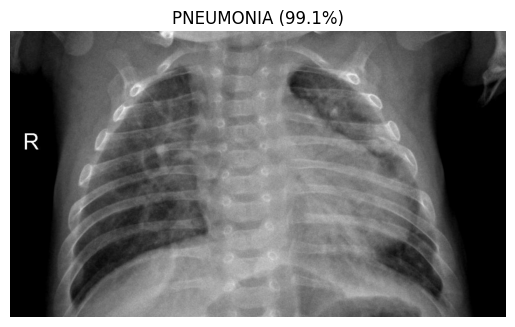

In [ ]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F

# ===============================
# Load trained DeepCNN model
# ===============================
class DeepCNN(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        def block(c_in, c_out):
            return nn.Sequential(
                nn.Conv2d(c_in, c_out, kernel_size=3, padding=1),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.Conv2d(c_out, c_out, kernel_size=3, padding=1),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )
        self.features = nn.Sequential(
            block(3, 32), block(32, 64), block(64, 128),
            block(128, 256), block(256, 512)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# Initialize model and load weights
model_pred = DeepCNN(n_classes=2).to(device)
model_pred.load_state_dict(torch.load("best_deepcnn.pth", map_location=device))
model_pred.eval()

# Class names (from dataset order: alphabetical)
class_names = ['NORMAL', 'PNEUMONIA']

# ===============================
# Upload an image
# ===============================
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Same preprocessing as training
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

# Open and preprocess
img = Image.open(img_path).convert("RGB")
x = transform(img).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    logits = model_pred(x)
    probs = F.softmax(logits, dim=1).squeeze().cpu().numpy()
    pred_idx = int(probs.argmax())
    pred_label = class_names[pred_idx]
    confidence = probs[pred_idx] * 100.0

# Show result
plt.imshow(img)
plt.axis("off")
plt.title(f"{pred_label} ({confidence:.1f}%)")
plt.show()
